In [1]:
import os
from pathlib import Path
import numpy as np
from keras.preprocessing import image
from keras.applications import vgg16
from keras.layers import Dense, Dropout, Flatten
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
import tensorflow as tf
NUM_PARALLEL_EXEC_UNITS = 4
config = tf.ConfigProto(intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS, inter_op_parallelism_threads=2,
                       allow_soft_placement=True, device_count={'CPU': NUM_PARALLEL_EXEC_UNITS})
session = tf.Session(config=config)
K.set_session(session)
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["KMP_BLOCKTIME"] = "30"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"

Using TensorFlow backend.


In [2]:
# Path to folders with training data
dog_path = Path("dogs-vs-cats/train/") / "dogs"
not_dog_path = Path("dogs-vs-cats/train/") / "not_dogs"

images = []
labels = []

In [3]:
# Load all the not-dog images
for img in not_dog_path.glob("*.jpg"):
    # Load the image from disk, resizing it to 224x224 pixels (required by this model)
    img = image.load_img(img, target_size=(224,224))

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)

    # Add the image to the list of images
    images.append(image_array)

    # For each 'not dog' image, the expected value should be 0
    labels.append(0)

In [4]:
# Load all the dog images
for img in dog_path.glob("*.jpg"):
    # Load the image from disk, resizing it to 224x224 pixels (required by this model)
    img = image.load_img(img, target_size=(224,224))

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)

    # Add the image to the list of images
    images.append(image_array)

    # For each 'dog' image, the expected value should be 1
    labels.append(1)

In [5]:
from sklearn.utils import shuffle
images, labels = shuffle(images, labels)


In [7]:
X = np.array(images).shape

In [9]:
X

(6596, 224, 224, 3)

In [10]:
X = np.array(images)

# Also convert the labels to a numpy array
y = np.array(labels)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [11]:
X_train.shape

(4419, 224, 224, 3)

In [13]:
# Normalize image data to 0-to-1 range
X_train = vgg16.preprocess_input(X_train)
X_test = vgg16.preprocess_input(X_test)

In [14]:
X_test.shape

(2177, 224, 224, 3)

In [21]:
# Load a pre-trained neural network to use as a feature extractor
# set include_top = False to remove the top layer to be replaced by our own classifier
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [22]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
# Define the layers in the new classification prediction 
from keras.models import Model
x = base_model.output
x = Flatten()(x)
x = Dense(224, activation='relu')(x)        # new FC layer, random init
x = Dense(224, activation='relu')(x)        # new FC layer, random init
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)  # new softmax layer

# Define trainable model which links input from the  base model to the new classification prediction layers
model = Model(inputs=base_model.input, outputs=predictions)

# print model structure diagram
print (model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [28]:
# Transfer Learning
print ('\nPerforming Transfer Learning')
  #   Freeze all layers in the vgg16 base model 

for layer in base_model.layers:
  print(layer)
  layer.trainable = False
#   Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Performing Transfer Learning


In [29]:
# Train the model
model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test,y_test)
)

Train on 4419 samples, validate on 2177 samples
Epoch 1/20
4419/4419 [==============================] - 1316s 298ms/step - loss: 1.8214 - acc: 0.8812 - val_loss: 2.2959 - val_acc: 0.8562
Epoch 2/20
4419/4419 [==============================] - 1204s 272ms/step - loss: 1.4546 - acc: 0.9081 - val_loss: 2.0287 - val_acc: 0.8714
Epoch 3/20
4419/4419 [==============================] - 949s 215ms/step - loss: 2.3928 - acc: 0.8495 - val_loss: 1.8306 - val_acc: 0.8852
Epoch 4/20
4419/4419 [==============================] - 948s 215ms/step - loss: 2.1543 - acc: 0.8647 - val_loss: 3.2510 - val_acc: 0.7960
Epoch 5/20
4419/4419 [==============================] - 942s 213ms/step - loss: 1.5047 - acc: 0.9061 - val_loss: 1.1952 - val_acc: 0.9256
Epoch 6/20
4419/4419 [==============================] - 943s 213ms/step - loss: 1.1805 - acc: 0.9265 - val_loss: 1.7642 - val_acc: 0.8902
Epoch 7/20
4419/4419 [==============================] - 939s 213ms/step - loss: 2.5748 - acc: 0.8402 - val_loss: 2.4802 - 

In [31]:
predictions = model.predict(X_test)

In [36]:
# test out for one image
images = []
for img in dog_path.glob("*.jpg"):
    # Load the image from disk
    img = image.load_img(img, target_size=(224,224))

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)

    # Add the image to the list of images
    images.append(image_array)

    # For each 'dog' image, the expected value should be 1
    labels.append(1)
    
    break;


In [37]:
X = np.array(images)

In [38]:
X.shape

(1, 224, 224, 3)

In [39]:
image_array.shape

(224, 224, 3)

In [40]:
predictions = model.predict(X)

In [41]:
print(predictions)

[[1.]]


## Model Tuning 

In [42]:
# Fine Tuning
Layers_To_Freeze = 19
for layer in base_model.layers[:Layers_To_Freeze]:
  layer.trainable = False
for layer in base_model.layers[Layers_To_Freeze:]:
  layer.trainable = True

for layer in base_model.layers:
    print(layer)
    print(layer.trainable)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [43]:
#   Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# Train the model
## Also introduce early stopping


In [45]:

# The patience parameter is the amount of epochs to check for improvement
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [47]:
model.fit( X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test,y_test),callbacks=[early_stop] )

Train on 4419 samples, validate on 2177 samples
Epoch 1/20
4419/4419 [==============================] - 1535s 347ms/step - loss: 1.0536 - acc: 0.9344 - val_loss: 1.2262 - val_acc: 0.9237
Epoch 2/20
4419/4419 [==============================] - 1698s 384ms/step - loss: 1.1351 - acc: 0.9289 - val_loss: 0.9152 - val_acc: 0.9430
Epoch 3/20
4419/4419 [==============================] - 1756s 397ms/step - loss: 2.3241 - acc: 0.8556 - val_loss: 3.0651 - val_acc: 0.8098
Epoch 4/20
4419/4419 [==============================] - 1840s 416ms/step - loss: 1.7354 - acc: 0.8923 - val_loss: 1.7837 - val_acc: 0.8893
Epoch 5/20
4419/4419 [==============================] - 1411s 319ms/step - loss: 1.6552 - acc: 0.8973 - val_loss: 1.7837 - val_acc: 0.8893
Epoch 6/20
4419/4419 [==============================] - 1498s 339ms/step - loss: 1.5559 - acc: 0.9025 - val_loss: 1.9924 - val_acc: 0.8751
Epoch 7/20
4419/4419 [==============================] - 1709s 387ms/step - loss: 1.1580 - acc: 0.9278 - val_loss: 1.14

## Tuning -  Using ImageDataGenerator

In [48]:
# construct the training image generator for data augmentation
gen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,horizontal_flip=True)
 
# train the network
H = model.fit_generator(gen.flow( X_train, y_train, batch_size=32),validation_data=(X_test,y_test), steps_per_epoch=len(X_train) // 32, epochs=30,callbacks=[early_stop])

Epoch 1/30
138/138 [==============================] - 1535s 11s/step - loss: 1.6575 - acc: 0.8965 - val_loss: 1.2387 - val_acc: 0.9224
Epoch 2/30
138/138 [==============================] - 1428s 10s/step - loss: 1.3138 - acc: 0.9179 - val_loss: 1.1509 - val_acc: 0.9279
Epoch 3/30
138/138 [==============================] - 1449s 10s/step - loss: 1.4260 - acc: 0.9109 - val_loss: 1.2094 - val_acc: 0.9242
Epoch 4/30
138/138 [==============================] - 1390s 10s/step - loss: 1.8998 - acc: 0.8811 - val_loss: 2.7521 - val_acc: 0.8273
Epoch 5/30
138/138 [==============================] - 1500s 11s/step - loss: 2.1267 - acc: 0.8666 - val_loss: 1.1809 - val_acc: 0.9260
Epoch 6/30
138/138 [==============================] - 1380s 10s/step - loss: 1.8542 - acc: 0.8836 - val_loss: 1.3269 - val_acc: 0.9169
Epoch 7/30
138/138 [==============================] - 1461s 11s/step - loss: 1.4882 - acc: 0.9074 - val_loss: 0.9988 - val_acc: 0.9375
Epoch 8/30
138/138 [==============================] - 1

Test loss: 1.103439244515724
Test accuracy: 0.9306384933394579


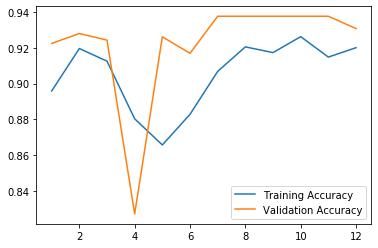

In [50]:
#   Evaluate the model with the test data to get the scores on "real" data.
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(H.history['acc']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, H.history['acc'], epoch_list, H.history['val_acc'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()